Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

Часть открытых данных есть, например, на сайте archive.org:

https://archive.org/details/201309_foursquare_dataset_umn

Скачаем любым удобным образом архив fsq.zip с этой страницы.

Для удобной работы с этим документом преобразуем его к формату csv, удалив строки, не содержащие координат — они неинформативны для нас

In [99]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift 
import matplotlib.pyplot as plt
%matplotlib inline

In [91]:
data = pd.read_csv('checkins.csv', sep = '|',skipinitialspace = True,skip_blank_lines = True)
data.columns

Index([u'id    ', u'user_id ', u'venue_id ', u'latitude      ',
       u'longitude     ', u'created_at      '],
      dtype='object')

In [54]:
# выбираем нужные столбцы
my_data = data.iloc[:, 3:5]
# удаляем пустые значения
my_data = my_data.dropna()
# возьмем первые 100000 значений
my_data_short = my_data.iloc[0:100001,:]
#print my_data_short

С помощью pandas построим DataFrame и убедимся, что все 396634 строки с координатами считаны успешно.

Теперь необходимо кластеризовать данные координаты, чтобы выявить центры скоплений туристов. Поскольку баннеры имеют сравнительно небольшую площадь действия, нам нужен алгоритм, позволяющий ограничить размер кластера и не зависящий от количества кластеров.

Эта задача — хороший повод познакомиться с алгоритмом MeanShift, который мы обошли стороной в основной части лекций. Его описание при желании можно посмотреть в sklearn user guide, а чуть позже появится дополнительное видео с обзором этого и некоторых других алгоритмов кластеризации. Используйте MeanShift, указав bandwidth=0.1, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах

Примечание: на 396634 строках кластеризация будет работать долго. Быть очень терпеливым не возбраняется — результат от этого только улучшится. Но для того, чтобы сдать задание, понадобится сабсет из первых 100 тысяч строк. Это компромисс между качеством и затраченным временем. Обучение алгоритма на всём датасете занимает около часа, а на 100 тыс. строк — примерно 2 минуты, однако этого достаточно для получения корректных результатов.

Некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения.

При желании увидеть получившиеся результаты на карте можно передать центры получившихся кластеров в один из инструментов визуализации. Например, сайт mapcustomizer.com имеет функцию Bulk Entry, куда можно вставить центры полученных кластеров в формате: 

38.8951118,-77.0363658

33.800745,-84.41052

45.5234515,-122.6762071

In [65]:
# выберем метод
my_MeanShift = MeanShift(bandwidth=0.1)
# построим кластеры
my_clusters = my_MeanShift.fit(my_data_short)

In [67]:
# разделим наши координаты по кластерам
preds = my_MeanShift.fit_predict(my_data_short)

(array([ 91596.,   4888.,   1904.,    948.,    665.]),
 array([    0. ,   645.6,  1291.2,  1936.8,  2582.4,  3228. ]),
 <a list of 5 Patch objects>)

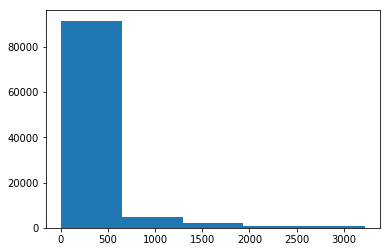

In [104]:
labels = my_clusters.labels_
# выберем кластеры с элементами больше 15
plt.hist(labels, 5)

(100001L,)


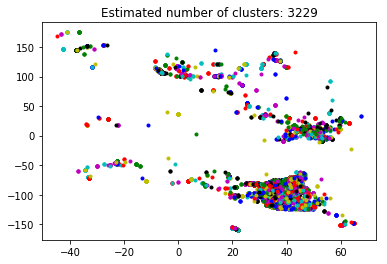

In [114]:
# кусок кода с форума для визуализации
from itertools import cycle

X=np.array(my_data_short)

labels = my_clusters.labels_
cluster_centers = my_clusters.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

print labels.shape 

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members,0],X[my_members,1],col + '.' )#Пространство признаков с выделенными разными цветами кластерами
    #plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
           #  markeredgecolor='k', markersize=14)#центры кластеров
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [122]:
# найдем кластеры с количеством жлементов больше 15
val, counts = np.unique(my_clusters.labels_, return_counts=True)
index_ar = []
for i in enumerate(counts):
    if i[1]>15:
        index_ar.append(i[0])
center_clusters_more_15 = my_clusters.cluster_centers_[index_ar]

592


Адреса офисов

33.751277, -118.188740 (Los Angeles)

25.867736, -80.324116 (Miami)

51.503016, -0.075479 (London)

52.378894, 4.885084 (Amsterdam)

39.366487, 117.036146 (Beijing)

-33.868457, 151.205134 (Sydney)

Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

Примечание: при подсчете расстояний и в кластеризации можно пренебречь тем, что Земля круглая, так как в точках, расположенных близко друг к другу погрешность мала, а в остальных точках значение достаточно велико.

Для сдачи задания выберите из получившихся 20 центров тот, который наименее удален от ближайшего к нему офиса. Ответ в этом задании — широта и долгота этого центра, записанные через пробел.

In [137]:
def find_dist (point_1,point_2):
    return ((point_2[0]-point_1[0])**2+(point_2[1]-point_1[1])**2)**0.5

# centers_coordinates = np.array([[33.751277, -118.188740, 'Los Angeles']
#                                ,[25.867736, -80.324116 , 'Miami']
#                                ,[51.503016, -0.075479 , 'London']
#                                ,[52.378894, 4.885084 , 'Amsterdam']
#                                ,[39.366487, 117.036146 , 'Beijing']
#                                ,[-33.868457, 151.205134 , 'Sydney']])
centers_coordinates = np.array([[33.751277, -118.188740]
                               ,[25.867736, -80.324116]
                               ,[51.503016, -0.075479]
                               ,[52.378894, 4.885084]
                               ,[39.366487, 117.036146]
                               ,[-33.868457, 151.205134]])

In [143]:
banners_coord_ind = []
banners_coord_dist = []
for centers in centers_coordinates:
    min_dist = 1000000
    for clusters in enumerate(center_clusters_more_15):
        finded_dist = find_dist(centers,clusters[1])
        if min_dist > finded_dist:
            min_dist = finded_dist
            ind_min_dist = clusters[0]
    banners_coord_ind.append(ind_min_dist) 
    banners_coord_dist.append(min_dist)  
print banners_coord_ind
print banners_coord_dist

[51, 404, 58, 376, 426, 409]
0.00783475816311


In [152]:
index = banners_coord_ind[banners_coord_dist.index(min(banners_coord_dist))]
center_clusters_more_15[index]

array([ -33.86063043,  151.20477593])